In [ ]:
# Install libs; rerun if kernel restarts
!pip install --upgrade pip
!pip install pandas numpy matplotlib seaborn prophet xgboost scikit-learn pmdarima openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 22.1 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.1/689.1 kB 10.4 MB/s  0:00:00


In [ ]:
from google.colab import files
uploaded = files.upload()   # choose your Sample - Superstore.csv.zip or .csv
for name in uploaded:
    print("Uploaded:", name)

Saving Sample - Superstore.csv.zip to Sample - Superstore.csv.zip
Uploaded: Sample - Superstore.csv.zip


In [ ]:
import zipfile, os, glob

# If you uploaded a zip named "Sample - Superstore.csv.zip" to current workspace
zip_path = "Sample - Superstore.csv.zip"
if os.path.exists(zip_path):
    with zipfile.ZipFile(zip_path, 'r') as z:
        z.extractall("superstore_extracted")
        print("Extracted:", z.namelist())

# Try to discover CSV if not zipped
csv_candidates = glob.glob("**/*.csv", recursive=False) + glob.glob("superstore_extracted/**/*.csv", recursive=True)
print("CSV candidates:", csv_candidates)

Extracted: ['Sample - Superstore.csv']
CSV candidates: ['superstore_extracted/Sample - Superstore.csv', 'sample_data/california_housing_test.csv', 'sample_data/mnist_test.csv', 'sample_data/california_housing_train.csv', 'sample_data/mnist_train_small.csv', 'superstore_extracted/Sample - Superstore.csv']


In [ ]:
import pandas as pd, os, glob

# adjust path if you mounted drive
# Example: csv_path = "/content/drive/MyDrive/data/Sample - Superstore.csv"
# If you extracted into superstore_extracted, use that.
candidates = glob.glob("superstore_extracted/*.csv") + glob.glob("*.csv")
if not candidates:
    raise FileNotFoundError("No CSV found; upload or set the correct path.")

csv_path = candidates[0]
print("Using CSV:", csv_path)

def try_read(path):
    for enc in ["utf-8", "latin1", "iso-8859-1", "cp1252"]:
        try:
            df = pd.read_csv(path, encoding=enc, low_memory=False)
            return df, enc
        except Exception as e:
            last=e
    raise last

df, used_enc = try_read(csv_path)
print("Loaded with encoding:", used_enc)
print("Shape:", df.shape)
df.head(5)

Using CSV: superstore_extracted/Sample - Superstore.csv
Loaded with encoding: latin1
Shape: (9994, 21)


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [ ]:
# Parse and standardize
df.columns = [c.strip() for c in df.columns]   # trim whitespace
date_col = None
for c in ['Order Date','OrderDate','order_date','OrderDate ']:
    if c in df.columns:
        date_col = c
        break
if date_col is None:
    raise ValueError("No Order Date column found. Columns: " + str(df.columns.tolist()))

df[date_col] = pd.to_datetime(df[date_col], errors='coerce', dayfirst=False)
print("Parsed dates. Null dates:", df[date_col].isna().sum())

# Coerce numeric columns
for col in ['Sales','Quantity','Discount','Profit']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop rows missing critical info
df = df.dropna(subset=[date_col,'Sales'])
df = df.drop_duplicates()
print("After cleaning shape:", df.shape)

# Show some summary
print(df[['Sales','Quantity','Discount','Profit']].describe().round(2))
df.head(5)

Parsed dates. Null dates: 0
After cleaning shape: (9994, 21)
          Sales  Quantity  Discount   Profit
count   9994.00   9994.00   9994.00  9994.00
mean     229.86      3.79      0.16    28.66
std      623.25      2.23      0.21   234.26
min        0.44      1.00      0.00 -6599.98
25%       17.28      2.00      0.00     1.73
50%       54.49      3.00      0.20     8.67
75%      209.94      5.00      0.20    29.36
max    22638.48     14.00      0.80  8399.98


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


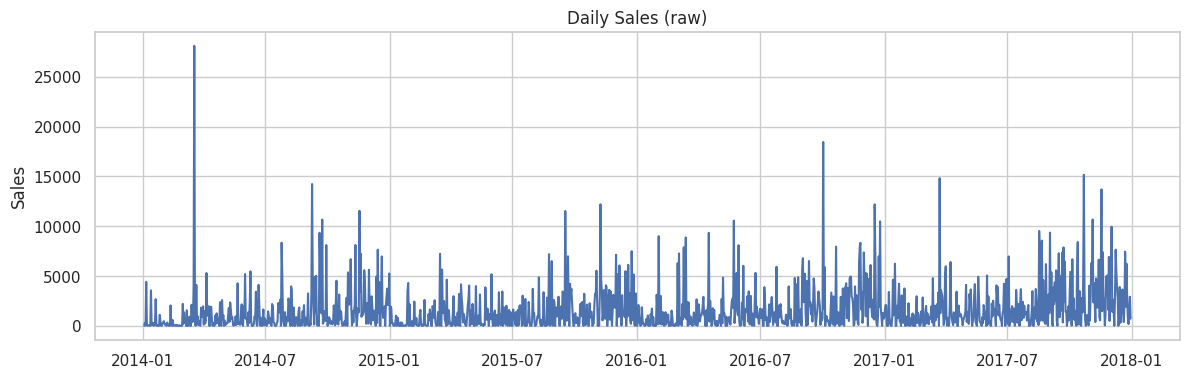

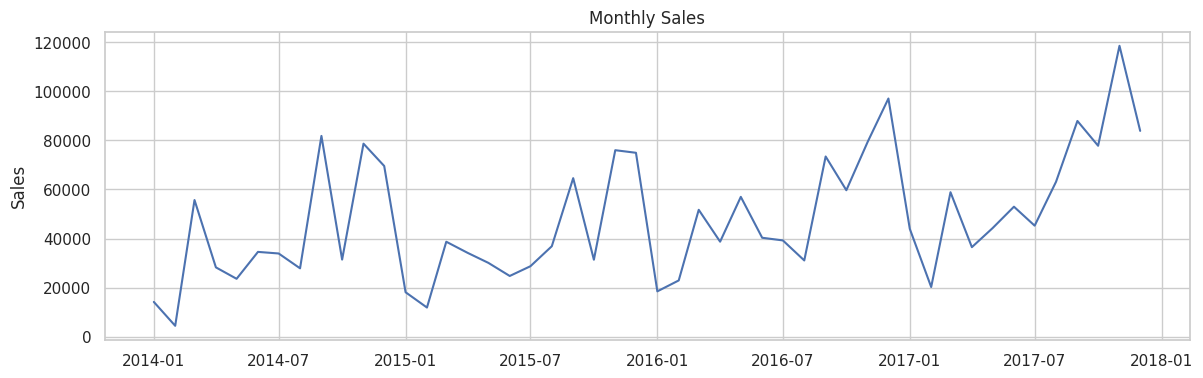

Top categories:
 Category
Technology         836154.0330
Furniture          741999.7953
Office Supplies    719047.0320
Name: Sales, dtype: float64


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# set index
df = df.sort_values(date_col)
df.set_index(date_col, inplace=True)

# daily sales (resample to D)
daily = df['Sales'].resample('D').sum()
plt.figure(figsize=(14,4))
plt.plot(daily.index, daily.values)
plt.title("Daily Sales (raw)")
plt.ylabel("Sales")
plt.show()

# monthly sales
monthly = df['Sales'].resample('MS').sum().to_frame(name='sales')
plt.figure(figsize=(14,4))
plt.plot(monthly.index, monthly['sales'])
plt.title("Monthly Sales")
plt.ylabel("Sales")
plt.show()

# top categories
if 'Category' in df.columns:
    cat = df.reset_index().groupby('Category')['Sales'].sum().sort_values(ascending=False)
    print("Top categories:\n", cat)

In [ ]:
os.makedirs("outputs", exist_ok=True)
df.reset_index().to_csv("outputs/superstore_clean.csv", index=False)
monthly.to_csv("outputs/superstore_monthly.csv")
print("Saved: outputs/superstore_clean.csv and outputs/superstore_monthly.csv")

Saved: outputs/superstore_clean.csv and outputs/superstore_monthly.csv


In [ ]:
ts = monthly.copy()
ts['lag_1'] = ts['sales'].shift(1)
ts['lag_3'] = ts['sales'].shift(3)
ts['lag_12'] = ts['sales'].shift(12)
ts['roll_3'] = ts['sales'].shift(1).rolling(3).mean()
ts['roll_6'] = ts['sales'].shift(1).rolling(6).mean()
ts['month'] = ts.index.month
ts['year'] = ts.index.year
ts = ts.dropna()   # drop rows that lost data due to lagging
ts.tail()

,sales,lag_1,lag_3,lag_12,roll_3,roll_6,month,year
Order Date,,,,,,,,
2017-08-01,63120.8880,45264.4160,44261.1102,31115.3743,47502.417300,43033.712367,8,2017
2017-09-01,87866.6520,63120.8880,52981.7257,73410.0249,53789.009900,50170.338133,9,2017
2017-10-01,77776.9232,87866.6520,45264.4160,59687.7450,65417.318667,55002.721333,10,2017
2017-11-01,118447.8250,77776.9232,63120.8880,79411.9658,76254.821067,61878.619183,11,2017
2017-12-01,83829.3188,118447.8250,87866.6520,96999.0430,94697.133400,74243.071650,12,2017


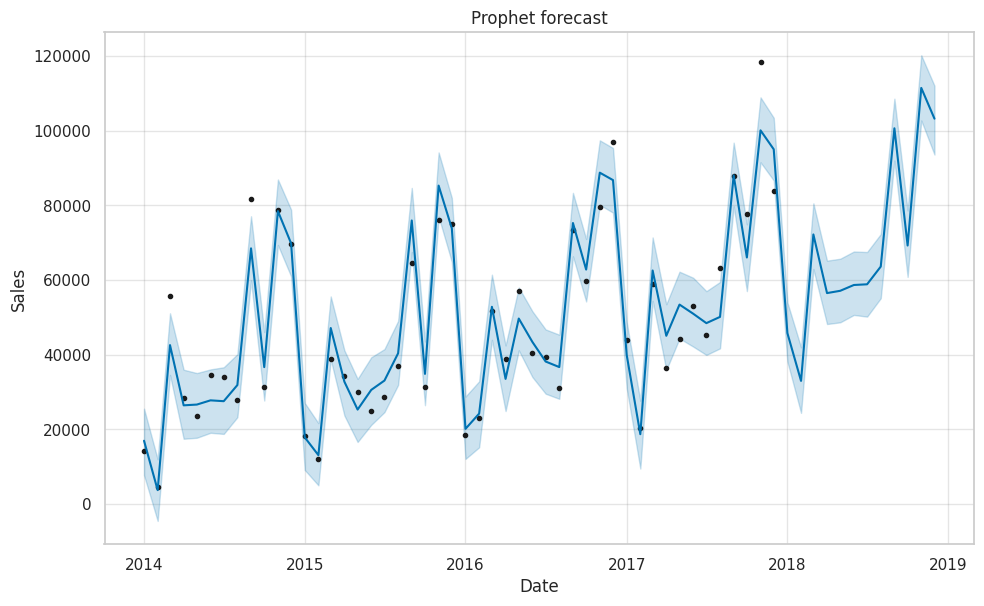

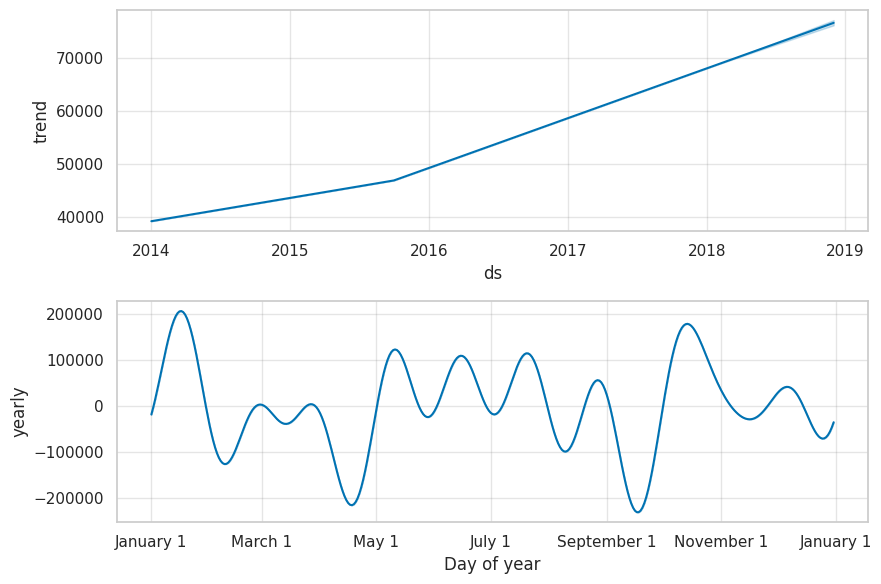

,ds,yhat,yhat_lower,yhat_upper
48,2018-01-01,45772.770289,38135.287698,53972.375511
49,2018-02-01,32975.255109,24411.480309,41971.555834
50,2018-03-01,72181.347658,62931.837079,80516.723652
51,2018-04-01,56487.020271,48204.177034,65168.175785
52,2018-05-01,57101.042386,48658.991279,65689.575182
53,2018-06-01,58654.769263,50638.658658,67624.481615
54,2018-07-01,58839.789909,50181.792013,67479.238864
55,2018-08-01,63583.395209,55109.919611,72282.770564
56,2018-09-01,100602.504323,91983.704198,108534.115300
57,2018-10-01,69219.824647,60816.078409,78599.180085


In [ ]:
from prophet import Prophet
prophet_df = monthly.reset_index().rename(columns={'index':'ds','sales':'y'}) if 'index' in monthly.reset_index().columns else monthly.reset_index().rename(columns={monthly.reset_index().columns[0]:'ds','sales':'y'})
prophet_df = prophet_df[['ds','y']]

m = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
# Add custom holidays (optional) — example:
# holidays = pd.DataFrame({'holiday': 'black_friday', 'ds': pd.to_datetime(['2019-11-29','2020-11-27']), 'lower_window': 0, 'upper_window': 1})
# m = Prophet(holidays=holidays)
m.fit(prophet_df)

future = m.make_future_dataframe(periods=12, freq='MS')  # forecast 12 months
forecast = m.predict(future)

# Plot forecast
fig1 = m.plot(forecast, xlabel='Date', ylabel='Sales')
plt.title("Prophet forecast")
plt.show()

# Components (trend, yearly seasonality)
fig2 = m.plot_components(forecast)
plt.show()

# Show last rows
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail(12)

In [ ]:
prophet_out = forecast[['ds','yhat','yhat_lower','yhat_upper']].merge(prophet_df, on='ds', how='left')
prophet_out = prophet_out.rename(columns={'y':'actual','yhat':'forecast','yhat_lower':'lower','yhat_upper':'upper'})
prophet_out.to_csv("outputs/forecast_for_powerbi_monthly.csv", index=False)
print("Saved forecast CSV:", "outputs/forecast_for_powerbi_monthly.csv")
prophet_out.tail(12)

Saved forecast CSV: outputs/forecast_for_powerbi_monthly.csv


,ds,forecast,lower,upper,actual
48,2018-01-01,45772.770289,38135.287698,53972.375511,NaN
49,2018-02-01,32975.255109,24411.480309,41971.555834,NaN
50,2018-03-01,72181.347658,62931.837079,80516.723652,NaN
51,2018-04-01,56487.020271,48204.177034,65168.175785,NaN
52,2018-05-01,57101.042386,48658.991279,65689.575182,NaN
53,2018-06-01,58654.769263,50638.658658,67624.481615,NaN
54,2018-07-01,58839.789909,50181.792013,67479.238864,NaN
55,2018-08-01,63583.395209,55109.919611,72282.770564,NaN
56,2018-09-01,100602.504323,91983.704198,108534.115300,NaN
57,2018-10-01,69219.824647,60816.078409,78599.180085,NaN


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
import numpy as np

data = ts.copy().dropna()
features = ['lag_1','lag_3','lag_12','roll_3','roll_6','month']
X = data[features].values
y = data['sales'].values

# time-based split: last 12 months for test
split_idx = len(X) - 12
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

model = XGBRegressor(objective='reg:squarederror', n_estimators=200)
model.fit(X_train, y_train)
preds = model.predict(X_test)

def mape(a,b): return np.mean(np.abs((a-b)/a))*100
print("MAE:", mean_absolute_error(y_test, preds))
print("MAPE (%):", mape(y_test, preds).round(2))

# Feature importances
importances = model.feature_importances_
for f,imp in zip(features, importances):
    print(f, round(imp,4))

MAE: 14597.409326171875
MAPE (%): 24.45
lag_1 0.0108
lag_3 0.0036
lag_12 0.8772
roll_3 0.0031
roll_6 0.0696
month 0.0357


In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
n_test = 12
preds_all = []
y_all = []

history = data.copy()
for i in range(n_test):
    train = history.iloc[:-n_test+i]
    test_row = history.iloc[-n_test+i]
    # Build features for the immediate next step using last available lags
    X_train = train[features].values
    y_train = train['sales'].values
    model = XGBRegressor(objective='reg:squarederror', n_estimators=200)
    model.fit(X_train, y_train)
    X_pred = test_row[features].values.reshape(1,-1)
    p = model.predict(X_pred)[0]
    preds_all.append(p)
    y_all.append(test_row['sales'])

print("Walk-forward MAPE:", mape(np.array(y_all), np.array(preds_all)).round(2))

Walk-forward MAPE: 28.83


In [ ]:
import joblib
os.makedirs("models", exist_ok=True)
joblib.dump(model, "models/xgb_model.joblib")
print("Saved XGBoost model to models/xgb_model.joblib")

Saved XGBoost model to models/xgb_model.joblib


In [ ]:
# If drive mounted:
# !cp outputs/forecast_for_powerbi_monthly.csv /content/drive/MyDrive/

# Or present download link in Colab:
from google.colab import files
files.download("outputs/forecast_for_powerbi_monthly.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>